### File for generating figures for DNN filter paper

In [1]:
#setup - rememeber to switch to tensorflow 2.3 kernel...
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import trimesh
import time
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 2*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

print(tf.__version__)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%matplotlib notebook

%load_ext tensorboard

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0


Autosaving every 180 seconds


In [11]:
#load mesh of object
surf_fn = "/home/derm/ASAR/v3/perspective_shift/figures/wall_scaled.stl"
M = trimesh.load(surf_fn)
#get ground truth translation
gt = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/figures/gt.txt")
print(gt)
#load point clouds of surface generated in Matlab
pts1_fn = "/home/derm/ASAR/v3/perspective_shift/figures/s1.txt"
pts1 = np.loadtxt(pts1_fn)
pts2_fn = "/home/derm/ASAR/v3/perspective_shift/figures/s2.txt"
pts2 = np.loadtxt(pts2_fn)
# pts = pts - gt #+ np.array([20,5,1.72])

#temp for making wall fig
pts2 = pts2[pts2[:,1] < -39]
pts1 = pts1[pts1[:,1] < -40]
print(np.shape(pts2))

[-40.  -40.   -5.2]
(1595, 3)


In [12]:
#plot with Vedo
plt1 = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp = []
disp.append(Points(pts1, c = 'red', r = 5, alpha = 1))
disp.append(Points(pts2 - np.array([1,1,0]), c = 'blue', r = 5, alpha = 1))
w1 = Mesh(M).c("gray").alpha(1)
w1.pos(gt[0], gt[1], gt[2])
print(gt[2])
# disp.append(w1)

# L = Light(pos = (30,30,30), focalPoint = (0,0,0), angle = 180, c = (1,1,1), intensity = 1, removeOthers = False)
# disp.append(L)

plt1.show(disp, "Fig 2.1")
ViewInteractiveWidget(plt1.window)

-5.2


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Plot Points + distributions

In [15]:
#Run ICET
import os
import sys
import inspect
# currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parentdir = os.path.dirname(os.path.dirname(currentdir))
# sys.path.insert(0, parentdir)

sys.path.insert(0,"/home/derm/ASAR/v3")

# print(currentdir)
# print(parentdir)
# print(sys.path)

from ICET_spherical import ICET

D = True
# D = False
it1 = ICET(cloud1 = pts1, cloud2 = pts2,  fid = 70, draw = D, 
            niter = 5, group= 2, RM = False, DNN_filter = False)

#add mesh to ICET visualization
w2 = Mesh(M).c("gray").alpha(0.25)
w2.pos(gt[0], gt[1], gt[2])
it1.disp.append(w2)
it1.plt.show(it1.disp, "Figure 2", resetcam = False)

ViewInteractiveWidget(it1.plt.window)

ModuleNotFoundError: No module named 'ICET_spherical'

# Missed Detection/ False Alarm plots

In [4]:
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
import numpy as np

plt.rcParams.update({
    "font.family": "serif",
    "font.sans-serif": ["Times"],
    "font.size": 12})

<IPython.core.display.Javascript object>


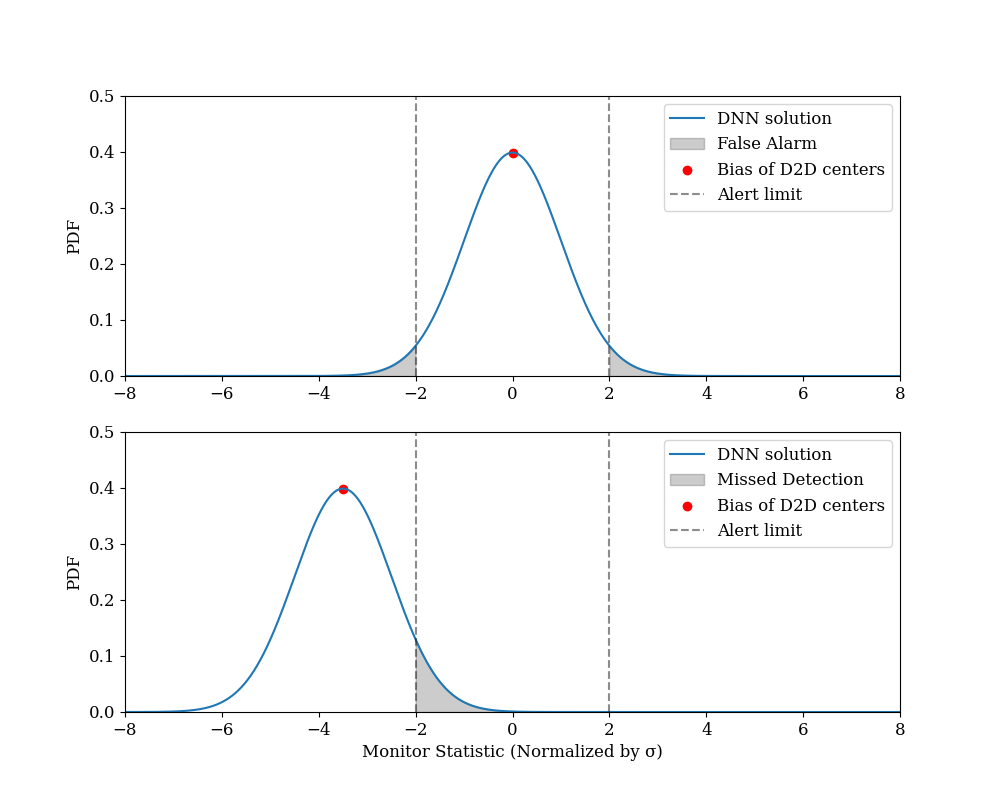

0.3989422804014327


In [5]:
#2 Sided Plots
fig, ax = plt.subplots(2,1)

thresh = 2
width = 8
xlim = 8
bias = -3.5

#Top Plot: 
x_data = np.arange(-width, width, 0.001)
y_data = stats.norm.pdf(x_data, 0, 1)
ax[0].plot(x_data, y_data, label = "DNN solution")
ax[0].set_ylim(0,0.5)
ax[0].set_xlim(-xlim,xlim)
ax[0].set_ylabel("PDF")
ax[0].fill_between(x_data[x_data > thresh],
                   stats.norm.pdf(x_data[x_data > thresh], 0, 1), 
                   color = [0,0,0], alpha = 0.2, label = 'False Alarm')
ax[0].fill_between(x_data[x_data < -thresh],
                   stats.norm.pdf(x_data[x_data < -thresh], 0, 1), 
                   color = [0,0,0], alpha = 0.2)
ax[0].scatter(0, np.max(y_data), color = (1,0,0), label = 'Bias of D2D centers')
ax[0].plot(thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5), label = "Alert limit")
ax[0].plot(-thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5))
ax[0].legend(loc = 'upper right')

#Bottom Plot
ax[1].set_xlabel("Monitor Statistic (Normalized by σ)")
ax[1].set_ylabel("PDF")
x_data = np.arange(-width, width, 0.001)
y_data = stats.norm.pdf(x_data-bias, 0, 1)
ax[1].plot(x_data, y_data, label = "DNN solution")
ax[1].set_ylim(0,0.5)
ax[1].set_xlim(-xlim,xlim)
ax[1].set_ylabel("PDF")
if bias > 0:
    ax[1].fill_between(x_data[x_data < thresh],
                       stats.norm.pdf(x_data[x_data < thresh] - bias, 0, 1), 
                       color = [0,0,0], alpha = 0.2, label = 'False Alarm')
if bias < 0:
    ax[1].fill_between(x_data[x_data > -thresh],
                       stats.norm.pdf(x_data[x_data > -thresh] - bias, 0, 1), 
                       color = [0,0,0], alpha = 0.2, label = 'Missed Detection')
ax[1].scatter(bias, np.max(y_data), color = (1,0,0), label = 'Bias of D2D centers')
ax[1].plot(thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5), label = "Alert limit")
ax[1].plot(-thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5))
ax[1].legend(loc = 'upper right')

print(np.max(y_data))

<IPython.core.display.Javascript object>


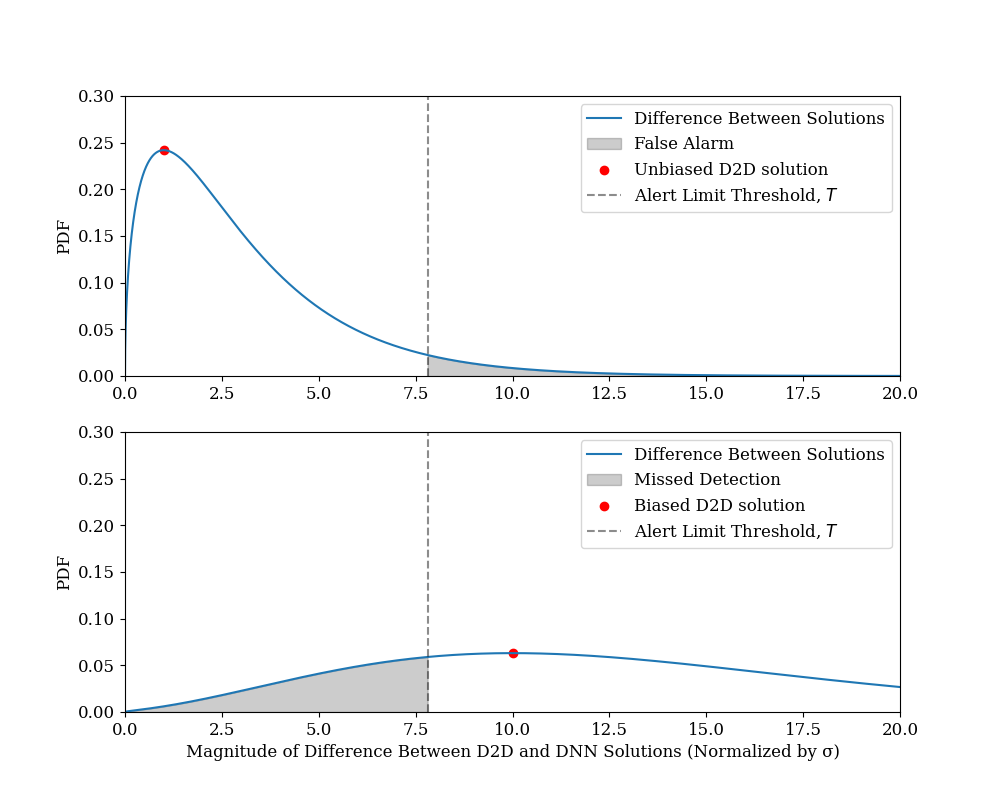

In [6]:
#1 Sided Plots
fig, ax = plt.subplots(2,1)

thresh = 7.81 #associated with 95% confidence bound for 3DOF chi-square with sigma=1
# thresh = 6.25 #90%
df = 3 #degrees of freedom
nc = 10 #Noncenterality Parameter gamma
width = 20
xlim = 20
stretch = 1 #larger number means more squish
thresh = thresh/stretch

#Top Plot:
x_data = np.arange(0, width, 0.001)
y_data = stats.chi2.pdf(x_data*stretch, df=3)

ax[0].plot(x_data, y_data, label = "Difference Between Solutions")
ax[0].set_ylim(0,0.3)
ax[0].set_xlim(0,xlim)
ax[0].set_ylabel("PDF")
ax[0].fill_between(x_data[x_data > thresh],
                   stats.chi2.pdf(stretch*x_data[x_data > thresh], df=3),
                   color = [0,0,0], alpha = 0.2, label = 'False Alarm')
# ax[0].scatter(x_data[1000], y_data[1000], color = (1,0,0), label = 'Bias of D2D solution')
ax[0].scatter(x_data[y_data == np.max(y_data)], np.max(y_data), color = (1,0,0), label = 'Unbiased D2D solution')
ax[0].plot(thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5), label = "Alert Limit Threshold, $T$")
ax[0].plot(-thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5))
ax[0].legend(loc = 'upper right')

#Bottom Plot - TODO- stretch this to start at 0
ax[1].set_xlabel("Magnitude of Difference Between D2D and DNN Solutions (Normalized by σ)")
ax[1].set_ylabel("PDF")
ax[1].set_ylim(0,0.3)
ax[1].set_xlim(0,xlim)
ax[1].set_ylabel("PDF")

#old (wrong) - using shifted chi-squre distribution---------------------------------------
# bias = 3
# ax[1].plot(x_data+bias, y_data, label = "Difference Between Solutions")
# ax[1].fill_between(x_data[x_data < thresh-bias] + bias,
#                        stats.chi2.pdf(stretch*x_data[x_data < thresh-bias], df=3),
#                        color = [0,0,0], alpha = 0.2, label = 'Missed Detection')
#new- Non-central Chi-Square distribution-------------------------------------------------
y_data_biased = stats.ncx2(df, nc).pdf(x_data*stretch)
ax[1].plot(x_data, y_data_biased, label = "Difference Between Solutions")
ax[1].fill_between(x_data[x_data < thresh],
                   y_data_biased[x_data < thresh],
                   color = [0,0,0], alpha = 0.2, label = 'Missed Detection')
#-----------------------------------------------------------------------------------------

ax[1].scatter(x_data[y_data_biased == np.max(y_data_biased)], np.max(y_data_biased), color = (1,0,0), label = 'Biased D2D solution')
ax[1].plot(thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5), label = "Alert Limit Threshold, $T$")
ax[1].plot(-thresh*np.ones([10,1]), np.linspace(0, 0.5, 10), ls = '--', color = (0.1, 0.1, 0.1, 0.5))
ax[1].legend(loc = 'upper right')


## Figure 1: draw multiple objects in same scene

In [8]:
# bgc = (0,0,0)
bgc = (1,1,1) #background color
mc  = (0.5,0.5,0.5) #'white' #
plt2 = Plotter(N = 1, axes = 4, bg = bgc, interactive = True)
disp2 = []
alph = 0.8#alpha for points
rad = 4

#load point clouds
c1 = np.loadtxt('fig1_s1.txt') 
c2 = np.loadtxt('fig1_s2.txt')
gt = np.loadtxt('fig1_gt.txt')
print(gt)
ground = -2.55 #define ground height
c1_ground = c1[c1[:,2] < ground]
c2_ground = c2[c2[:,2] < ground]
c1 = c1[c1[:,2] > ground] #remove ground plane
c2 = c2[c2[:,2] > ground]

surf_fn = "Assembly1_scaled.stl"
M = trimesh.load(surf_fn)
w1 = Mesh(M).c(mc).alpha(1)
w1.pos(0, 0, -1.2)
w1.crop(bounds = [-10,10,-10,10,-1.45,5])
disp2.append(w1)

vox_fn = "voxel.stl"
v1 = Mesh(trimesh.load(vox_fn)).c((0,0,0)) #draw voxel around head of dummy
v1.pos(-5.5,7.5,0)
disp2.append(v1)

v2 = Mesh(trimesh.load(vox_fn)).c((0,0,0))
v2.pos(2.5,7,-1)
disp2.append(v2)


#add light 
# L = Light(pos = (0,-10,30), focalPoint = (0,0,0), angle = 180, c = (1,1,1), intensity = 1, removeOthers = False)
# disp2.append(L)

disp2.append(Points(c1, c = 'red', r = rad, alpha = alph))
disp2.append(Points(c2 - gt/10, c = 'blue', r = rad, alpha = alph))
disp2.append(Points(c1_ground, c = 'red', r = rad, alpha = alph/4))
disp2.append(Points(c2_ground - gt/10, c = 'blue', r = rad, alpha = alph/4))

plt2.show(disp2, "Figure 1")
ViewInteractiveWidget(plt2.window)

[100.   0.   0.]


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Experiment 2: Correcting ICET Estimates with DNN

In [9]:
import matplotlib.pyplot as plt
%matplotlib notebook
# font = {'fontname':'Times New Roman'}

# ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/ICET_estimates_v8.txt") #best old DNN (from spring...)

# #0005 ~~~~~~~~~~~
# ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_CompactNet_5cmThresh.txt") #CompactNet.kmod 
# # ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_CompactNet_2cmThresh.txt") #CompactNet.kmod 
# OXTS_baseline = np.loadtxt("/home/derm/ASAR/v3/OXTS_baseline_v17.txt")
# BC = np.loadtxt("/home/derm/ASAR/v3/Before_correction_v18.txt") #actually before correction
# # BC = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_CompactNet_5cmThresh.txt") #CompactNet.kmod 
# # ICET_pred_stds = np.loadtxt("/home/derm/ASAR/v3/ICET_pred_stds_v13.txt") #old (for debug)
# ICET_pred_stds = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_pred_stds_2cmThresh.txt")
# #~~~~~~~~~~~~~~~~

# #0095~~~~~~~~~~~~
# ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0095_CompactNet.txt") #CompactNet.kmod 
# OXTS_baseline = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0095_OXTS_baseline_gps.txt")
# ICET_pred_stds = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0005_pred_stds.txt")
# BC = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0095_noDNN.txt")
# #~~~~~~~~~~~~~~~~

# #0027~~~~~~~~~~~~
# ICET_estimates = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027_CompactNet_5cmThresh.txt") #CompactNet.kmod 
# OXTS_baseline = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027_OXTS_baseline_gps.txt")
# ICET_pred_stds = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027_pred_stds.txt")
# BC = np.loadtxt("/home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027_noDNN.txt")
# #~~~~~~~~~~~~~~~~

# OXTS_baseline = (OXTS_baseline/0.1*0.1037 + OXTS_baseline)/2 #correct for timing differences
OXTS_baseline = OXTS_baseline/0.1*0.1037  #correct for timing differences


# ICET_estimates[:,0] = ICET_estimates[:,0]/tvec*0.1

#fix sign errors
ICET_estimates[:,1] = -ICET_estimates[:,1]
ICET_estimates[:,3:] = -ICET_estimates[:,3:]
BC[:,1] = -BC[:,1]
BC[:,3:] = -BC[:,3:]

style1 = 'b-'
style2 = 'r-'
style3 = 'b--'

gt_fwd = np.sqrt(OXTS_baseline[:,0]**2 + OXTS_baseline[:,1]**2)

fig, ax = plt.subplots(2,1, constrained_layout = True)
ax[0].plot(BC[:,0], style3, label = 'NDT, no correction', alpha = 0.3)
ax[0].plot(ICET_estimates[:,0], style1, label = 'NDT, corrected with DNN')
ax[0].plot(gt_fwd, style2, label = 'GPS/INS Baseline')
# ax[0,0].plot(np.sqrt(OXTS_baseline[:,0]**2 + OXTS_baseline[:,1]**2), style2, label = 'GPS/INS Baseline')
ax[0].set_title("change in x per frame")
ax[0].set_ylabel("dx (m)")
ax[0].legend(loc = 'best')
ax[0].set_xlabel("frame")

ax[1].plot(np.rad2deg(BC[:,5]), style3, alpha = 0.3, label = "NDT - no correction")
ax[1].plot(np.rad2deg(ICET_estimates[:,5]), style1, lw = 1, label = "NDT - corrected with DNN")
ax[1].plot(np.rad2deg(OXTS_baseline[:,5]), style2, lw = 1)
ax[1].set_title("change in yaw per frame")
ax[1].set_ylabel("dyaw (deg)")
ax[1].set_xlabel("frame")
ax[1].legend(loc = 'best')


# fig.tight_layout(h_pad = 0.1)
plt.show()

FileNotFoundError: /home/derm/ASAR/v3/perspective_shift/sim_results/KITTI_0027_CompactNet_5cmThresh.txt not found.

<IPython.core.display.Javascript object>


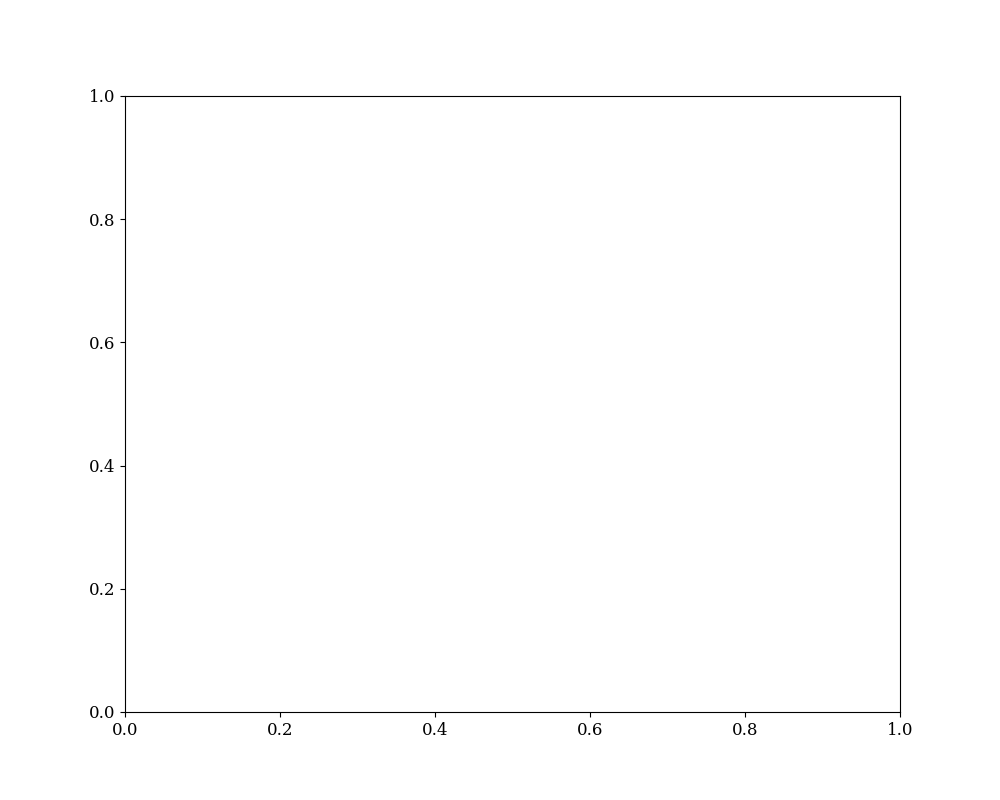

NameError: name 'OXTS_baseline' is not defined

In [10]:
#plot error between ICET and absolute position
fig3, ax3 = plt.subplots(1,1)

#which component to look at
# c = 5 #yaw
c = 0 # x (forward movement)

diffx = OXTS_baseline[:,c] - ICET_estimates[:,c]
diffx_BC = OXTS_baseline[:,c] - BC[:,c]

# print(abs(diffx))
print("correlation coefficient \n", np.corrcoef(abs(diffx), ICET_pred_stds[:,0]))

#flip sign when looking at yaw
if c ==5:
    diffx = -diffx 
    diffx_BC = -diffx_BC
    
cum_err = np.zeros(np.shape(ICET_pred_stds))
cum_diffx = np.zeros(np.shape(diffx))
cum_diffx_BC = np.zeros(np.shape(diffx_BC))

for i in range(np.shape(ICET_pred_stds)[0]):
    cum_err[i,:] = np.sum(ICET_pred_stds[:i,:]**2, axis = 0)
    #add in baseline OXTS 1-sigma errors
    cum_err[i,:] += np.sqrt(2)*np.array([0.05,0.05,0.1,0.0005,0.0005,0.001])**2
#     cum_err[i,:] += np.sqrt(2)*np.array([0.08,0.08,0.1,0.0005,0.0005,0.001745])**2
    cum_err[i,:] = np.sqrt(cum_err[i,:]) 
    
for j in range(np.shape(diffx)[0]):
    cum_diffx[j] = np.sum(diffx[:j]) 
    cum_diffx_BC[j] = np.sum(diffx_BC[:j]) 

# # #old (error for each individual timestep)------------------------
# ax3.plot(diffx, label = 'GPS/INS - NDT (with DNN)')
# ax3.plot(diffx_BC, 'b--', label = 'GPS/INS - NDT (no DNN)', alpha = 0.3)
# ax3.fill_between(np.linspace(0,150,np.shape(ICET_pred_stds)[0]), -2*ICET_pred_stds[:,c], 2*ICET_pred_stds[:,c], 
#                  color = (0.5,0.5,0.5,0.4), label = 'ICET Predicted 2σ Error Bounds')
# #-------------------------------------------------------------------

# #new (accumulated differences in error)--------------------------
# ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx_with_ground, label = 'GPS/INS - ICET')
ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx, label = 'GPS/INS - ICET (after correction)')
ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx_BC, 'b--', alpha = 0.3, label = 'GPS/INS - ICET (before correction)')
ax3.fill_between(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), -2*cum_err[:,c], 2*cum_err[:,c], 
                 color = (0,0,1,0.2), label = 'Predicted 2σ Error Bounds')
# # --------------------------------------------------------------------

# ax3.legend(loc = 'lower left')
ax3.legend(loc = 'best')
ax3.set_title("Predicted vs Actual Error in x")
ax3.set_xlabel("time (s)", **font)
ax3.set_ylabel("GPS/INS Baseline x - Odometry Estimate x (m)", **font)
# ax3.set_title("Predicted vs Actual Error in yaw")
# ax3.set_xlabel("time (s)", **font)
# ax3.set_ylabel("GPS/INS Baseline yaw - Odometry Estimate yaw (rad)", **font)
# ax3.set_ylim(-0.032,0.045)
# ax3.set_ylim([-0.07,0.07])